In [7]:
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from diffuse.noise_scheduler import NoiseScheduler
from dataclasses import dataclass
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from diffuse.utils import image_grid
from torch.optim import Adam
from diffuse.models.unet2 import UNet


@dataclass
class Config:
    experiment_name: str = 'base'
    dataset: str = 'fashion_mnist'
    train_batch_size: int = 128
    eval_batch_size: int = 1000
    num_epochs: int = 20
    learning_rate: float = 1e-3
    num_timesteps: int = 300
    beta_schedule: str = "log2"
    beta_start: float = .0001
    beta_end:float = .02
    # embedding_size: int = 128
    # hidden_size: int = 128
    # hidden_layers: int = 3
    # time_embedding: str = "sinusoidal"
    # input_embedding: str = "sinusoidal"
    # save_images_step: int = 1
c = Config()

In [8]:
# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

noise_scheduler = NoiseScheduler(num_timesteps=c.num_timesteps, beta_schedule=c.beta_schedule,
                                 beta_start=c.beta_start,beta_end=c.beta_end)

In [9]:
# define image transformations (e.g. using torchvision)
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

reverse_transform = transforms.Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: rearrange(t, 'c h w -> h w c')), 
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

# define function
def t(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(t).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


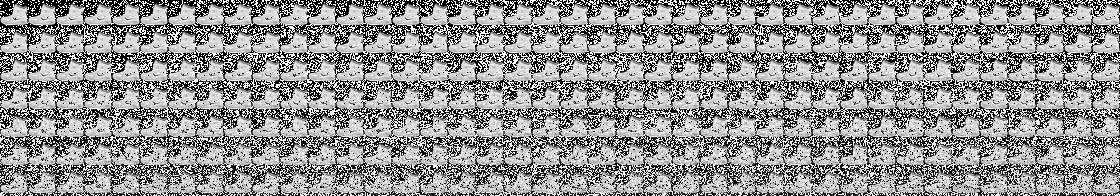

In [10]:
x_0 = dataset.with_transform(t).remove_columns("label")['train'][:2]['pixel_values']
x_0 = torch.stack(x_0,0)
x = x_0.repeat_interleave(c.num_timesteps,0)
timesteps = torch.arange(c.num_timesteps).repeat_interleave(2,0)
x_noised = noise_scheduler.add_noise(x, torch.randn_like(x),timesteps)

z = [reverse_transform(x_) for x_ in x_noised]
image_grid(list(z[:c.num_timesteps]),40)

In [15]:
device = "cpu"
model = UNet(image_channels=1, n_blocks=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=c.learning_rate)

In [16]:
global_step = 0
losses = []
epoch_to_samples = dict()

print("Training model...")

for epoch in range(c.num_epochs):
    model.train()
    for step, batch in enumerate(dataloader):
        batch = batch['pixel_values']
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy.to(device), timesteps.to(device))
        loss = F.mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(float(loss.detach().item()))

        # progress_bar.set_postfix(**logs)
        if global_step % 300 == 0:
            loss = sum(losses[-30:])/min(30,len(losses)) # running loss
            print(f'e{epoch}|s{global_step} loss={loss:.2f}')

        global_step += 1

    if epoch % c.save_images_step == 0 or epoch == c.num_epochs - 1:
        epoch_to_samples[epoch]=model.sample(noise_scheduler)

Training model...


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 7 for tensor number 1 in the list.

In [ ]:
%debug

> /mnt/nas/user/spock/projects/Diffusion/diffuse/models/unet2.py(414)forward()
    412                 # Get the skip connection from first half of U-Net and concatenate
    413                 s = h.pop()
--> 414                 x = torch.cat((x, s), dim=1)
    415                 #
    416                 x = m(x, t)



ipdb>  p x.shape


torch.Size([128, 256, 8, 8])


ipdb>  p t.shape


torch.Size([128, 256])


In [14]:
%debug

> /mnt/nas/user/spock/projects/Diffusion/diffuse/models/unet2.py(414)forward()
    412                 # Get the skip connection from first half of U-Net and concatenate
    413                 s = h.pop()
--> 414                 x = torch.cat((x, s), dim=1)
    415                 #
    416                 x = m(x, t)



ipdb>  p s.shape


torch.Size([128, 256, 7, 7])


ipdb>  p x.shape


torch.Size([128, 256, 8, 8])


ipdb>  q


In [18]:
Unet

diffuse.models.unet.Unet